In [1]:
import pandas as pd
import numpy as np
import fastf1
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

2025-02-21 11:17:51.749677: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-21 11:17:51.804390: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-21 11:17:51.805435: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-21 11:17:52.881581: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Prep dataset

In [ ]:
df = pd.read_csv('/home/riccardo/Documents/F1/dataset/dataset_best_driver.csv')
# df = pd.read_csv('/home/riccardo/Visual_Studio_Code/F1/dataset/dataset_best_driver.csv')

df = df.drop('Unnamed: 0',axis=1)

from sklearn.preprocessing import LabelEncoder

In [23]:
df['Grand Prix'].nunique()

22

In [ ]:
# Filtrer pour un Grand Prix spécifique, par exemple : Bahrain Grand Prix
# grand_prix_name = "Bahrain Grand Prix"
# df_gp = df[df['Grand Prix'] == grand_prix_name].reset_index(drop=True)

# Encoder les noms des Grands Prix en numéros uniques
gp_encoder = LabelEncoder()
df['Grand Prix'] = gp_encoder.fit_transform(df['Grand Prix'])
# Vérifier l'encodage
print(dict(zip(gp_encoder.classes_, gp_encoder.transform(gp_encoder.classes_))))

((1100, 6), (1100, 1))

In [24]:
# Vérifier s'il y a 50 sections pour le circuit
df_gp_50 = df

# Préparer l'entrée (X, Y, Angle, Straight_Line, Speed) et la sortie (Best_Driver)
input_features = df_gp_50[['X', 'Y', 'Angle', 'Straight_Line','Grand Prix','Speed']].fillna(0) 
output_best_driver = df_gp_50[['Best_Driver']]

# Vérifier les dimensions des données d'entrée et de sortie
input_features.shape, output_best_driver.shape


((1100, 6), (1100, 1))

In [25]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# Normaliser les données d'entrée
scaler = StandardScaler()
input_features_scaled = scaler.fit_transform(input_features)

# Encoder les pilotes
label_encoder = LabelEncoder()
output_best_driver_encoded = label_encoder.fit_transform(output_best_driver.values.flatten())


In [29]:

# Reshape pour correspondre au format attendu par l'LSTM
X_data = input_features_scaled.reshape(22, 50, 6)  # 1 échantillon (le Grand Prix), 50 sections, 5 features
y_data = output_best_driver_encoded.reshape(22, 50, 1)  # 1 échantillon, 50 sections, 1 label

# Définir le modèle LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(22,50, 6), return_sequences=True))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compiler le modèle
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping pour éviter le surapprentissage
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Entraîner le modèle
model.fit(X_data, y_data, epochs=200, batch_size=1, callbacks=[early_stopping])


ValueError: Input 0 of layer "lstm_4" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 22, 50, 6)

1/1 [==============================] - 0s 396ms/step


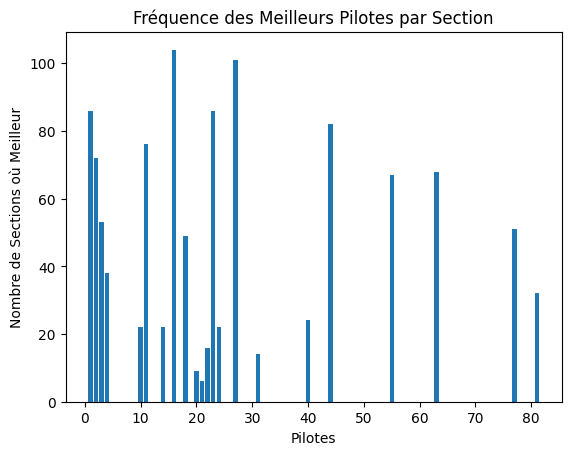

Le pilote dominant pour ce circuit est : 16


In [22]:

# Faire des prédictions
y_pred = model.predict(X_data)
y_pred_classes = y_pred.argmax(axis=-1).flatten()

# Décoder les prédictions pour obtenir les noms/numéros des pilotes
y_pred_drivers = label_encoder.inverse_transform(y_pred_classes)

# Calculer la fréquence des meilleurs pilotes
unique, counts = np.unique(y_pred_drivers, return_counts=True)
driver_counts = dict(zip(unique, counts))

# Afficher les résultats
plt.bar(driver_counts.keys(), driver_counts.values())
plt.xlabel('Pilotes')
plt.ylabel('Nombre de Sections où Meilleur')
plt.title('Fréquence des Meilleurs Pilotes par Section')
plt.show()

# Pilote dominant
dominant_driver = max(driver_counts, key=driver_counts.get)
print(f"Le pilote dominant pour ce circuit est : {dominant_driver}")


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Charger les données
df = pd.read_csv('/home/riccardo/Documents/F1/dataset/dataset_best_driver.csv')
df = df.drop('Unnamed: 0', axis=1)

# Encoder les noms des Grands Prix en numéros uniques
gp_encoder = LabelEncoder()
df['Grand Prix'] = gp_encoder.fit_transform(df['Grand Prix'])

# Vérifier le nombre de circuits disponibles
print("Nombre de circuits disponibles :", df['Grand Prix'].nunique())

# Sélectionner les features d'entrée et de sortie
input_features = df[['X', 'Y', 'Angle', 'Straight_Line', 'Speed', 'Grand Prix']].fillna(0)
output_best_driver = df[['Best_Driver']]

# Normalisation des données d'entrée
scaler = StandardScaler()
input_features_scaled = scaler.fit_transform(input_features)

# Encoder les pilotes
label_encoder = LabelEncoder()
output_best_driver_encoded = label_encoder.fit_transform(output_best_driver.values.flatten())

# Vérifier la forme des données avant reshape
print("Shape of input_features_scaled:", input_features_scaled.shape)  # Devrait être (1100, 6)
print("Shape of output_best_driver_encoded:", output_best_driver_encoded.shape)  # Devrait être (1100,)

# Reshape pour correspondre au format attendu par l'LSTM
num_gp = df['Grand Prix'].nunique()  # Nombre total de circuits (ex : 22)
sections_per_gp = 50  # Nombre de sections par circuit

X_data = input_features_scaled.reshape(num_gp, sections_per_gp, 6)  # 22 circuits, 50 sections, 6 features
y_data = output_best_driver_encoded.reshape(num_gp, sections_per_gp, 1)  # 22 circuits, 50 sections, 1 label



Nombre de circuits disponibles : 22
Shape of input_features_scaled: (1100, 6)
Shape of output_best_driver_encoded: (1100,)


In [36]:
# Définir le modèle LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(50, 6), return_sequences=True))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compiler le modèle
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping pour éviter le surapprentissage
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Entraîner le modèle
model.fit(X_data, y_data, epochs=100, batch_size=4, callbacks=[early_stopping])


Epoch 1/100
6/6 [==============================] - 2s 10ms/step - loss: 3.0960 - accuracy: 0.0291
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 3.0656 - accuracy: 0.0436
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 3.0432 - accuracy: 0.0709
Epoch 4/100
6/6 [==============================] - 0s 13ms/step - loss: 3.0233 - accuracy: 0.0909
Epoch 5/100
6/6 [==============================] - 0s 11ms/step - loss: 3.0011 - accuracy: 0.1145
Epoch 6/100
6/6 [==============================] - 0s 11ms/step - loss: 2.9827 - accuracy: 0.1236
Epoch 7/100
6/6 [==============================] - 0s 18ms/step - loss: 2.9615 - accuracy: 0.1300
Epoch 8/100
6/6 [==============================] - 0s 13ms/step - loss: 2.9403 - accuracy: 0.1400
Epoch 9/100
6/6 [==============================] - 0s 12ms/step - loss: 2.9189 - accuracy: 0.1400
Epoch 10/100
6/6 [==============================] - 0s 12ms/step - loss: 2.8962 - accuracy: 0.1464
Epoch 11/100
6/6 [=

1/1 [==============================] - 0s 331ms/step


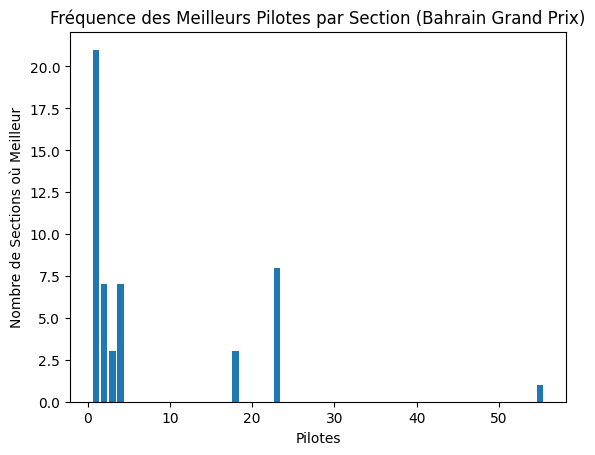

Le pilote dominant pour Bahrain Grand Prix est : 1


In [37]:
# Sélectionner un circuit spécifique pour la prédiction (ex: "Bahrain Grand Prix")
grand_prix_name = "Bahrain Grand Prix"
grand_prix_num = gp_encoder.transform([grand_prix_name])[0]

# Filtrer uniquement ce circuit
df_gp = df[df['Grand Prix'] == grand_prix_num].reset_index(drop=True)

# Vérifier s'il y a 50 sections pour ce circuit
if df_gp.shape[0] < 50:
    raise ValueError("Il y a moins de 50 sections pour ce Grand Prix !")

df_gp_50 = df_gp.iloc[:50]  # Sélectionner les 50 premières sections

# Sélectionner les features d'entrée
input_features_test = df_gp_50[['X', 'Y', 'Angle', 'Straight_Line', 'Speed', 'Grand Prix']].fillna(0)

# Normaliser les données d'entrée avec le scaler entraîné
input_features_scaled_test = scaler.transform(input_features_test)

# Reshape pour correspondre au format LSTM
X_test = input_features_scaled_test.reshape(1, 50, 6)  # 1 circuit, 50 sections, 6 features

# Faire des prédictions
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1).flatten()

# Décoder les prédictions pour obtenir les noms/numéros des pilotes
y_pred_drivers = label_encoder.inverse_transform(y_pred_classes)

# Calculer la fréquence des meilleurs pilotes
unique, counts = np.unique(y_pred_drivers, return_counts=True)
driver_counts = dict(zip(unique, counts))

# Afficher les résultats
plt.bar(driver_counts.keys(), driver_counts.values())
plt.xlabel('Pilotes')
plt.ylabel('Nombre de Sections où Meilleur')
plt.title(f'Fréquence des Meilleurs Pilotes par Section ({grand_prix_name})')
plt.show()

# Pilote dominant
dominant_driver = max(driver_counts, key=driver_counts.get)
print(f"Le pilote dominant pour {grand_prix_name} est : {dominant_driver}")
